### Tutorial 1: Vorhersage von Netzlasten

Datenaufteilung: Teilen Sie die Zeitreihendaten in 70% Training, 15% Validierung und 15% Test auf, wobei die zeitliche Reihenfolge erhalten bleibt (kein Shuffling).

In [35]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

df_load = pd.read_csv('../data/processed/Load_history.csv')
df_temp = pd.read_csv('../data/processed/temperature_history.csv')

df_temp = df_temp.rename(columns={'station_id': 'zone_id', 'value': 'temp'})
df_load= df_load.rename(columns={'value': 'load'})

df_merged = pd.merge(df_load, df_temp, on=['timestamp', 'zone_id'], how='inner')
df_merged = df_merged.dropna()

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['dayofyear'] = df_merged['timestamp'].dt.dayofyear
df_merged['weekday'] = df_merged['timestamp'].dt.weekday

#print(df_merged)

# TVT-Split: 75% Training, 15% Validierung, 15% Test

# Eingabe- und Zielvariablen aus df_merged definieren
X = df_merged[['temp', 'zone_id', 'hour', 'dayofyear', 'weekday']]
y = df_merged['load']


# TVT-Split: 70% Training, 15% Validierung, 15% Test (zeitlich sortiert, kein Shuffle)
n = len(df_merged)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]


## Modellentwicklung: 
### Entwickeln Sie zwei verschiedene Modelle zur Vorhersage der Netzlast z.B.:
Modell 1: Lineare Regression mit Prädiktoren wie Wochentag, Stunde des Tages, Temperatur und einer Interaktion zwischen Wochentag und Stunde.

In [36]:
X1_train = sm.add_constant(X_train)
X1_val = sm.add_constant(X_val)
X1_test = sm.add_constant(X_test)

modell1 = sm.OLS(y_train, X1_train).fit()

Modell 2: Entscheidungsbaum mit denselben Prädiktoren, ergänzt um eine Transformation (z. B. quadratische Temperatur).

In [37]:
modell2 = DecisionTreeRegressor(random_state=42)
modell2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

## Fehlerbewertung: 
### Berechnen Sie den MAPE für Trainings-, Validierungs- und Testsets für beide Modelle.

In [38]:

# MSE für Modell 1 (OLS)
mse1_train = np.mean((y_train - modell1.predict(X1_train)) ** 2)
mse1_val = np.mean((y_val - modell1.predict(X1_val)) ** 2)
mse1_test = np.mean((y_test - modell1.predict(X1_test)) ** 2)

# MSE für Modell 2 (DecisionTreeRegressor) – ACHTUNG: hier X_* ohne Konstante
mse2_train = np.mean((y_train - modell2.predict(X_train)) ** 2)
mse2_val = np.mean((y_val - modell2.predict(X_val)) ** 2)
mse2_test = np.mean((y_test - modell2.predict(X_test)) ** 2)

# Ausgabe
print("MSE für Modell 1 (OLS):")
print("   ➤ Train      :", mse1_train)
print("   ➤ Validation :", mse1_val)
print("   ➤ Test       :", mse1_test)

print("\nMSE für Modell 2 (DecisionTreeRegressor):")
print("   ➤ Train      :", mse2_train)
print("   ➤ Validation :", mse2_val)
print("   ➤ Test       :", mse2_test)


MSE für Modell 1 (OLS):
   ➤ Train      : 19215.35768047346
   ➤ Validation : 16128.745865633082
   ➤ Test       : 21044.443078247838

MSE für Modell 2 (DecisionTreeRegressor):
   ➤ Train      : 0.0
   ➤ Validation : 606.0154627733663
   ➤ Test       : 963.8554040044892


## Visualisierung: 
### Erstellen Sie eine interaktive Zeitreihenvisualisierung mit Plotly, die die tatsächliche Netzlast und die Vorhersagen beider Modelle für das Testset darstellt.

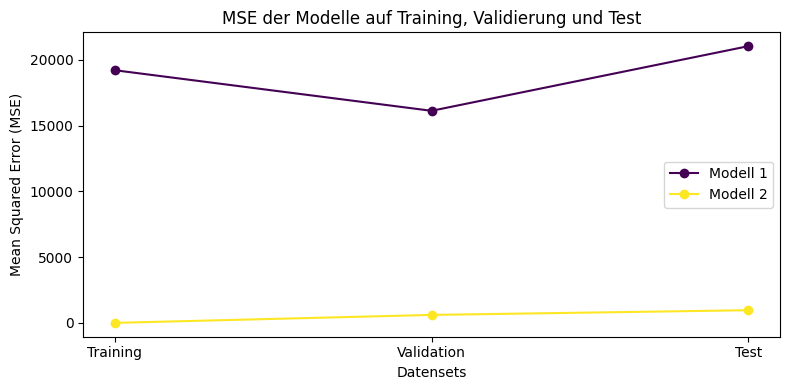

In [39]:
# Plot der MSE-Werte
plt.figure(figsize=(8, 4))  # Kleinere Größe
models = ["Modell 1", "Modell 2"]
sets = ["Training", "Validation", "Test"]
mse_values = [
    [mse1_train, mse1_val, mse1_test],
    [mse2_train, mse2_val, mse2_test]
]

# Verwende viridis-Farbpalette
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Scatterplot mit verbundenen Linien
for i, model in enumerate(models):
    plt.plot(sets, mse_values[i], marker='o', linestyle='-', color=colors[i], label=model)

plt.xlabel("Datensets")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE der Modelle auf Training, Validierung und Test")
plt.legend()
plt.tight_layout()
plt.show()